In [ ]:
from __future__ import print_function, division
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import cv2
import os
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import copy, pickle, os, time
import argparse 
from google.colab import drive
import random
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from __future__ import print_function
import torch, os, copy, time, pickle
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
from torchvision.datasets.folder import IMG_EXTENSIONS
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix
import glob, pickle
import seaborn as sn
import argparse
start_time= time.time()
import tensorflow as tf
from tensorflow import keras
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from skimage.io import imread
import PIL
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_dir='/content/gdrive/MyDrive/data2/'
batch_size = 20

In [ ]:

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]) , 
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])}

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size= batch_size,
                                             shuffle=True, num_workers= num_workers)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes  ## 0: child, and 1: nonchild


In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
      

        im = Image.open(os.path.join(folder,filename))
        img = cv2.imread(os.path.join(folder,filename))
        if im is not None:
            images.append(im)
    return images

# **code**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
start_time= time.time()
epochs = 100


In [ ]:
def train_model(model, criterion, optimizer, scheduler, batch_szie, num_epochs= 20):
    since = time.time()
    
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc= list()
    valid_acc= list()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_prec= 0.0
            running_rec = 0.0
            running_f1  = 0.0

            # Iterate over data.
            cur_batch_ind= 0
            for inputs, labels in dataloaders[phase]:
                #print(cur_batch_ind,"batch inputs shape:", inputs.shape)
                #print(cur_batch_ind,"batch label shape:", labels.shape)
                inputs = inputs.to(device)
                labels = labels.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                cur_acc= torch.sum(preds == labels.data).double()/batch_szie
                cur_batch_ind +=1
                print("\npreds:", preds)
                print("label:", labels.data)
                print("%d-th epoch, %d-th batch (size=%d), %s acc= %.3f \n" %(epoch+1, cur_batch_ind, len(labels), phase, cur_acc ))
                
                if phase=='train':
                    train_acc.append(cur_acc)
                else:
                    valid_acc.append(cur_acc)
                
            epoch_loss= running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f} \n\n'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch= epoch
                best_model_wts = copy.deepcopy(model.state_dict())



    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc= %.3f at Epoch: %d' %(best_acc,best_epoch) )

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc, valid_acc

In [ ]:
sm = torch.nn.Softmax()

In [ ]:

def testmodel(testimage , cut_off_threshold):
  print('test size is : ' ,len(testimage) , 'sample')
  coivdpred = list()
  noncovidpred = list()
  totalpred = list()
  grandth = list()

  for  inputs, labels in testimage :
    cur_img = inputs.reshape(1 , 3 , 224,224)
    out = model(cur_img)
    cur_prob2 = sm(out)

    if float(cur_prob2[0][0])> cut_off_threshold:
      out2 = 0 
      coivdpred.append(0)
      totalpred.append(out2)
      grandth.append(labels)

    else:
      out2 = 1 
      totalpred.append(out2)
      noncovidpred.append(1)
      grandth.append(labels)

  covid_prob = list() 
  non_prob = list()
  for  inputs, labels in testimage:
    cur_img = inputs.reshape(1 , 3 , 224,224)
    out = model(cur_img)
    cur_prob = sm(out)
    if labels == 0 :
        covid_prob.append(cur_prob.data.numpy()[0,0])
    if labels == 1 :
        non_prob.append(cur_prob.data.numpy()[0,0])
  k = 0
  for i in range(3100):
    if grandth[i] == 0 :
      if totalpred[i] == 1:
        k = k+1
  print('num of samples covid but predicted non covid :' ,k)
  l = 0
  for i in range(3100):
    if grandth[i] == 1 :
      if totalpred[i] == 0:
        l = l+1
  print('num of samples non covid but predicted covid :' , l)
  print('total cases that predicted as covid: ' , len(coivdpred))
  sensivity = (100 - k) / 100
  print('total cases that predicted as non covid :' ,len(noncovidpred))
  Specificity =  (3000 - l) / 3000
  print('Sensitivity is :',sensivity)
  print('Specificity is :', Specificity)
  ConfusionMatrix(totalpred , grandth)
  return covid_prob , non_prob ,coivdpred , noncovidpred


In [ ]:
def Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, cut_off_threshold):
  y_test_res18= [1 for i in range(len(covid_prob))]+[0 for i in range(len(non_prob))]
  y_pred_res18= [1 for i in range(len(coivdpred))]+[0 for i in range(len(noncovidpred))]

           
  auc_res18 = roc_auc_score(y_test_res18, y_pred_res18)
  ns_fpr_res18, ns_tpr_res18, _ = roc_curve(y_test_res18, y_pred_res18)

  plt.figure()
  pyplot.plot(ns_fpr_res18, ns_tpr_res18,  color='darkgreen', linewidth=2,   label='   AUC= %.3f'   %auc_res18) 
  pyplot.ylim([0,1.05])
  pyplot.xlabel('False Positive Rate')
  pyplot.ylabel('True Positive Rate')
  pyplot.title("ROC Curve threshold is %.2f "  %cut_off_threshold)
  pyplot.legend(loc='lower right')
  # plt.savefig('./ROC_covid19.png') 

In [ ]:
def Probabilties(covid_prob ,non_prob ):
  bins = np.linspace(0, 1, 25)
  plt.subplot(211)
  plt.hist(covid_prob, bins, color= 'blue', histtype = 'bar', label='Probabilities of COVID-19 Samples')
  plt.ylim([0,10])
  plt.legend(loc='upper center')
  plt.subplot(212)
  plt.hist(non_prob, bins, color= 'green', label='Probabilities of Non-COVID Samples')
  plt.legend(loc='upper center')
  plt.savefig('./scores_histogram.png') #dpi = 200

In [ ]:
def ConfusionMatrix(totalpred , grandth):
  y_pred= np.asarray(totalpred, dtype=np.int64)
  y_test= np.asarray(grandth, dtype=np.int64)
  cnf_matrix = confusion_matrix(y_test, y_pred)
  np.set_printoptions(precision=2)   
  df_cm = pd.DataFrame(cnf_matrix, index = [i for i in class_names],
                                 columns = [i for i in class_names])
  ax = sn.heatmap(df_cm, cmap=plt.cm.Blues, annot=True, cbar=False, fmt='g', xticklabels= ['COVID','Non-COVID'], yticklabels= ['COVID','Non-COVID'])
  ax.set_title("Confusion matrix")
  # plt.savefig('./confusion_matrix.png') 



# **DATA AG**

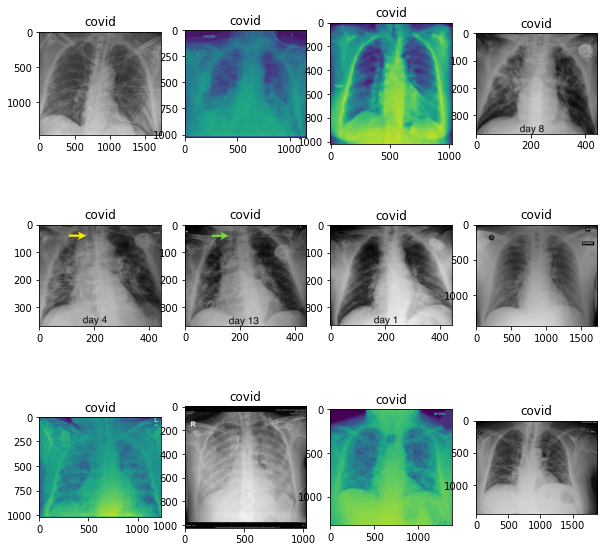

In [ ]:
plt.figure(figsize=(10,10))
for i in range(12):
    ax=plt.subplot(3,4,i+1)
    ax.title.set_text('covid')
    plt.imshow(train_covid[i])
plt.show()  # display it

In [ ]:
transforms1 = transforms.Compose([
        transforms.Resize((224,224)),
])

In [ ]:
print(train_covid[0].getbands())

('R', 'G', 'B')


In [ ]:
trainim_coivid = list()
for i in train_covid:
  j = transforms1(i)
  trainim_coivid.append(j)

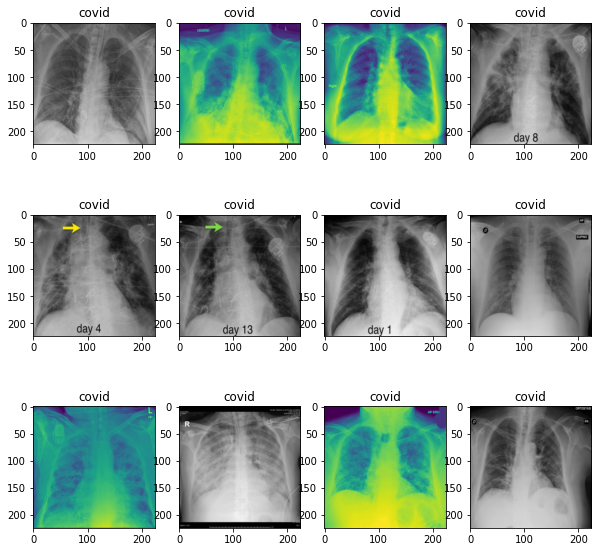

In [ ]:
plt.figure(figsize=(10,10))
for i in range(12):
    ax=plt.subplot(3,4,i+1)
    ax.title.set_text('covid')
    plt.imshow(trainim_coivid[i])
plt.show()  # display it

In [ ]:
transforms2 = transforms.Compose([
        transforms.RandomRotation((-10 , 10))
])

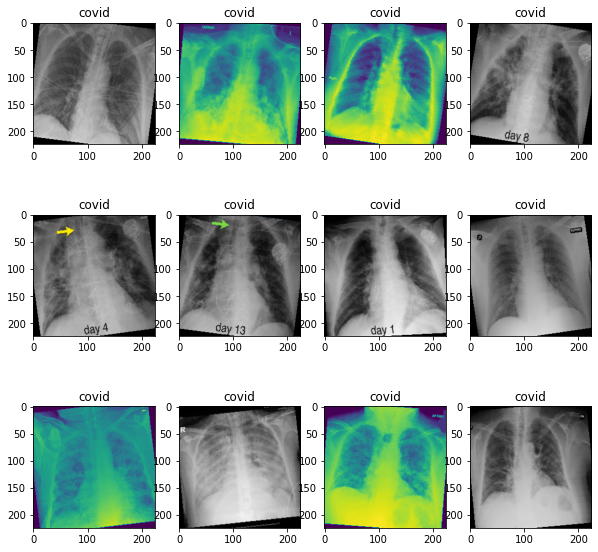

In [ ]:
trainim_coivid2 = list()
for i in trainim_coivid:
  j = transforms2(i)
  trainim_coivid2.append(j)

plt.figure(figsize=(10,10))
for i in range(12):
    ax=plt.subplot(3,4,i+1)
    ax.title.set_text('covid')
    plt.imshow(trainim_coivid2[i])
plt.show()  # display it

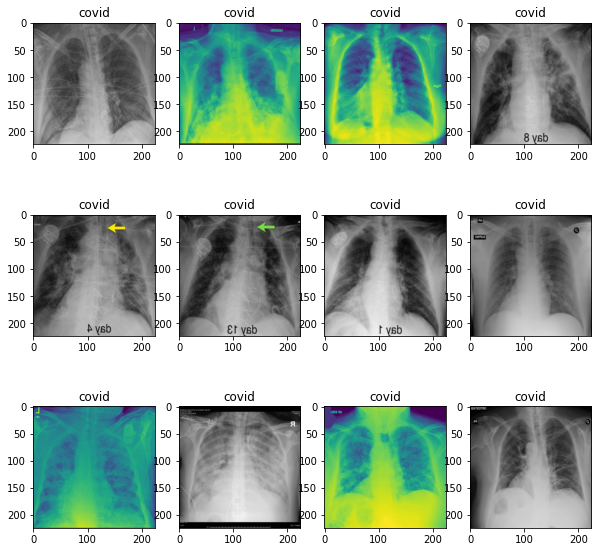

In [ ]:

transforms3 = transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip( p =1 )
])
trainim_coivid3 = list()
for i in trainim_coivid:
  j = transforms3(i)
  trainim_coivid3.append(j)

plt.figure(figsize=(10,10))
for i in range(12):
    ax=plt.subplot(3,4,i+1)
    ax.title.set_text('covid')
    plt.imshow(trainim_coivid3[i])
plt.show()  # display it

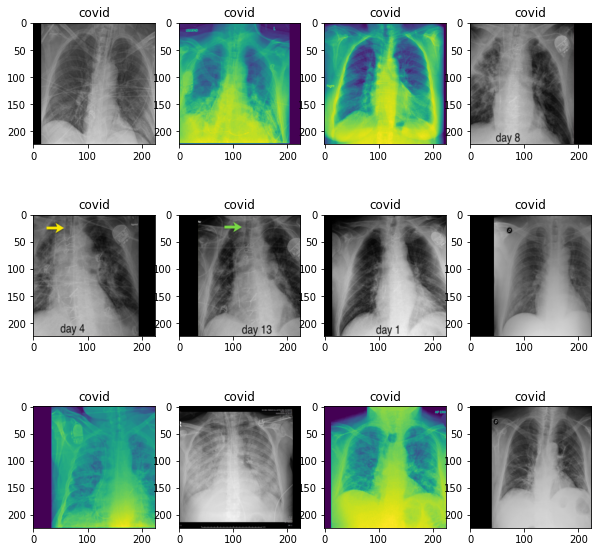

In [ ]:

transforms4 = transforms.Compose([
        transforms.RandomAffine(degrees  =0  ,translate = (0.2 , 0))

])
trainim_coivid4 = list()
for i in trainim_coivid:
  j = transforms4(i)
  trainim_coivid4.append(j)

plt.figure(figsize=(10,10))
for i in range(12):
    ax=plt.subplot(3,4,i+1)
    ax.title.set_text('covid')
    plt.imshow(trainim_coivid4[i])
plt.show()  # display it

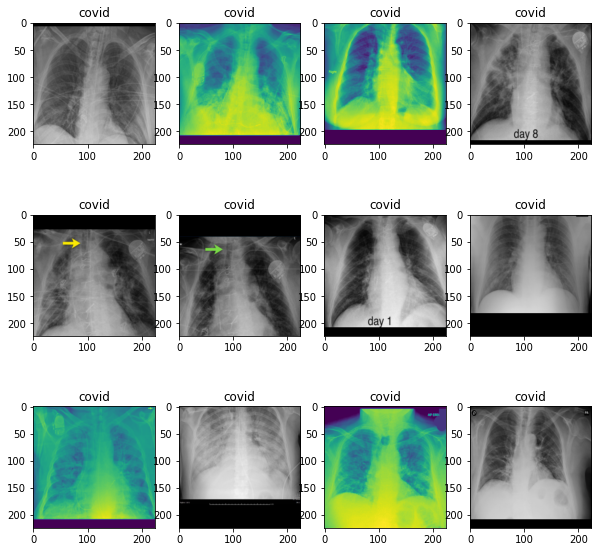

In [ ]:
transforms5 = transforms.Compose([
        transforms.RandomAffine(degrees  =0  ,translate = (0 , 0.2))
])
trainim_coivid5 = list()
for i in trainim_coivid:
  j = transforms5(i)
  trainim_coivid5.append(j)

plt.figure(figsize=(10,10))
for i in range(12):
    ax=plt.subplot(3,4,i+1)
    ax.title.set_text('covid')
    plt.imshow(trainim_coivid5[i])
plt.show()  # display it

In [ ]:
traincov_tot = trainim_coivid5 + trainim_coivid4 + trainim_coivid3 + trainim_coivid2 +trainim_coivid

420
<class 'list'>


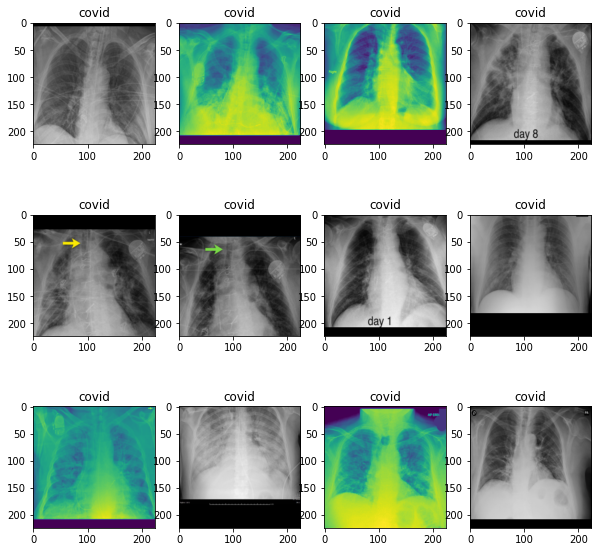

In [ ]:
print(len(traincov_tot))
print(type(traincov_tot))
plt.figure(figsize=(10,10))
for i in range(12):
    ax=plt.subplot(3,4,i+1)
    ax.title.set_text('covid')
    plt.imshow(traincov_tot[i])
plt.show()  # display it

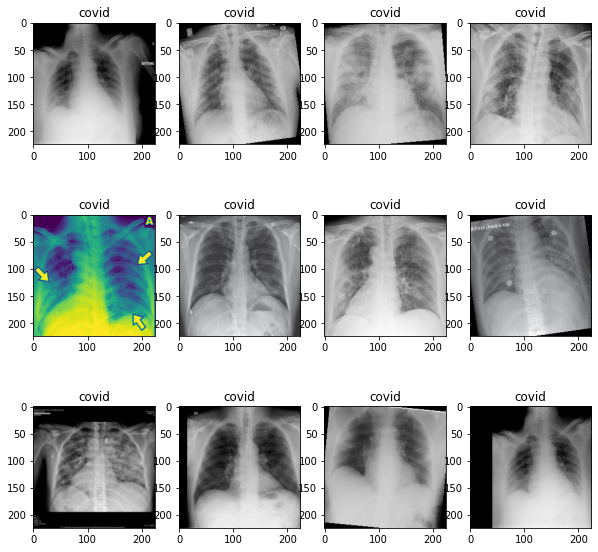

In [ ]:
random.shuffle(traincov_tot)

plt.figure(figsize=(10,10))
for i in range(12):
    ax=plt.subplot(3,4,i+1)
    ax.title.set_text('covid')
    plt.imshow(traincov_tot[i])
plt.show()  # display it

In [ ]:
import time

i = 0
for item in traincov_tot:
  item.save('/content/gdrive/MyDrive/data2/train/covid2/{}.png'.format(i))
  time.sleep(0.2) # Sleep for 3 seconds
  print(i)
  i = i +1

In [ ]:
train_noncovid = load_images_from_folder('/content/gdrive/MyDrive/data/train/non')

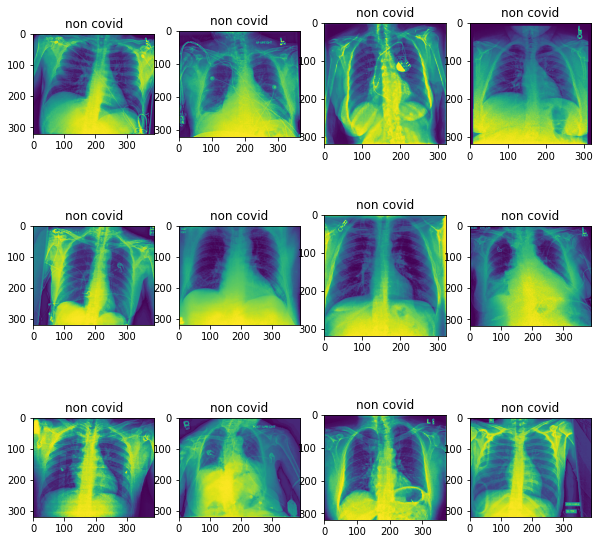

2000
<class 'list'>


In [ ]:

plt.figure(figsize=(10,10))
for i in range(12):
    ax=plt.subplot(3,4,i+1)
    ax.title.set_text('non covid')
    plt.imshow(train_noncovid[i])
plt.show()  # display it


print(len(train_noncovid))
print(type(train_noncovid))

# **2nd ResNet 50**

## **Code**

In [ ]:
#### load model
model_conv = torchvision.models.resnet50(pretrained=True)
i = 0 
for child  in model_conv.children():
        i = i +1
        if i >= 8 :
          for param in child.parameters():
              param.requires_grad = True
        else:
          for param in child.parameters():
              param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default   
num_ftrs = model_conv.fc.in_features        
model_conv.fc = nn.Linear(num_ftrs, 2)


model_conv = model_conv.to(device)  
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr= 0.001, momentum= 0.9)  

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# from torchsummary import summary

if __name__ == "__main__":
    model_conv, train_acc, valid_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, batch_size, num_epochs= epochs)
    model_conv.eval()
    torch.save(model_conv, './covid_resnet50_100_2_2.pt' )




end_time= time.time()
print("total_time tranfer learning=", end_time - start_time)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 1/100
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Streaming output truncated to the last 5000 lines.
       device='cuda:0')
label: tensor([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1],
       device='cuda:0')
98-th epoch, 118-th batch (size=20), train acc= 0.950 


preds: tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
98-th epoch, 119-th batch (size=20), train acc= 1.000 


preds: tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0],
       device='cuda:0')
98-th epoch, 120-th batch (size=20), train acc= 1.000 


preds: tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
98-th epoch, 121-th batch (size=20), train acc= 1.000 

In [ ]:
trained_model_path =  '/content/gdrive/MyDrive/covid_resnet50_100_2_2.pt'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name= trained_model_path
model= torch.load(model_name, map_location='cpu') 
model.eval()

class_names = ['covid','non']


## **Experiments**

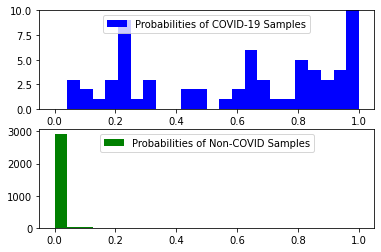

In [ ]:
Probabilties(covid_prob , non_prob)

### **Threshold = 0.03**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 0
num of samples non covid but predicted covid : 107
total cases that predicted as covid:  207
total cases that predicted as non covid : 2893
Sensitivity is : 1.0
Specificity is : 0.9643333333333334


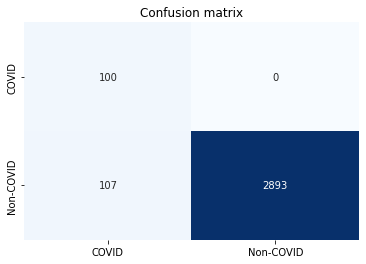

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.03)

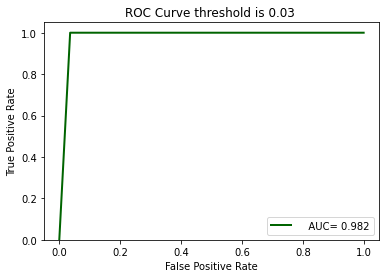

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.03)

### **Threshold = 0.1**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 4
num of samples non covid but predicted covid : 28
total cases that predicted as covid:  124
total cases that predicted as non covid : 2976
Sensitivity is : 0.96
Specificity is : 0.9906666666666667


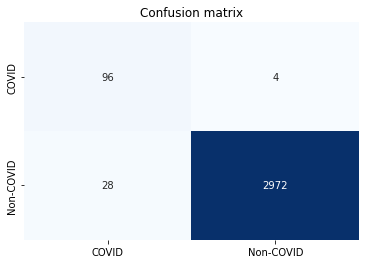

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.1)

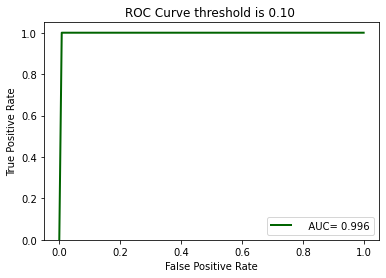

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.1)

### **Threshold = 0.15**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 6
num of samples non covid but predicted covid : 14
total cases that predicted as covid:  108
total cases that predicted as non covid : 2992
Sensitivity is : 0.94
Specificity is : 0.9953333333333333


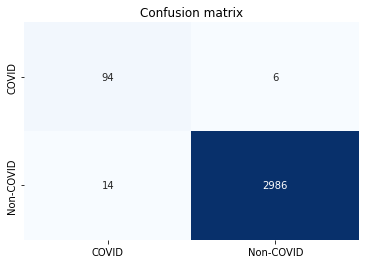

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.15)

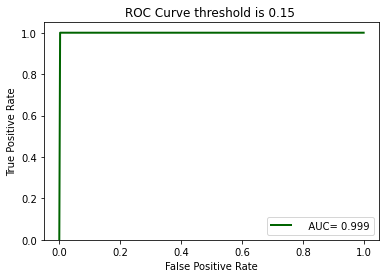

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.15)

### **Threshold = 0.17**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 6
num of samples non covid but predicted covid : 11
total cases that predicted as covid:  105
total cases that predicted as non covid : 2995
Sensitivity is : 0.94
Specificity is : 0.9963333333333333


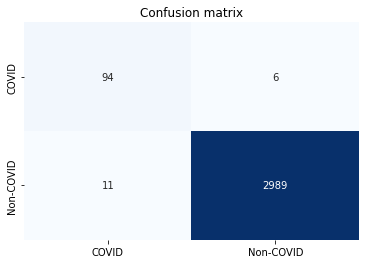

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.17)

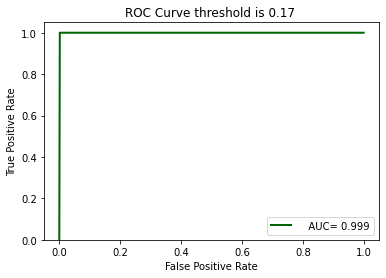

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.17)

### **Threshold = 0.19**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 8
num of samples non covid but predicted covid : 9
total cases that predicted as covid:  101
total cases that predicted as non covid : 2999
Sensitivity is : 0.92
Specificity is : 0.997


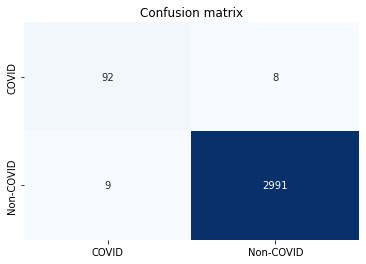

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.19)

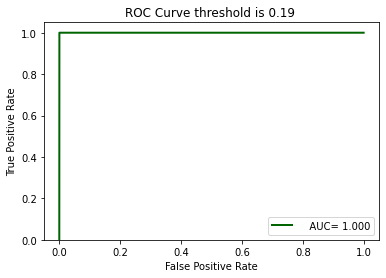

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.19)

### **Threshold = 0.2**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 9
num of samples non covid but predicted covid : 8
total cases that predicted as covid:  99
total cases that predicted as non covid : 3001
Sensitivity is : 0.91
Specificity is : 0.9973333333333333


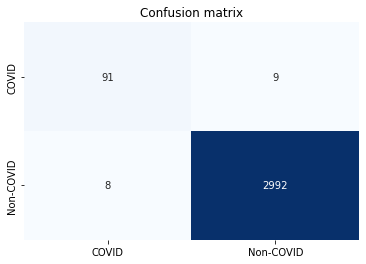

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.2)

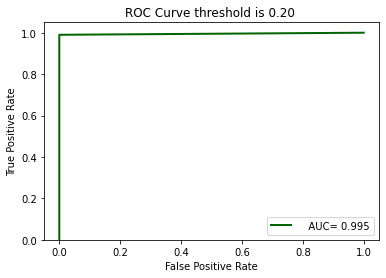

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.2)

### **Threshold = 0.25**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 18
num of samples non covid but predicted covid : 6
total cases that predicted as covid:  88
total cases that predicted as non covid : 3012
Sensitivity is : 0.82
Specificity is : 0.998


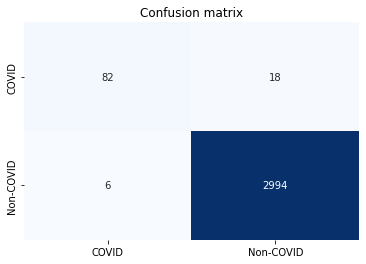

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.25)

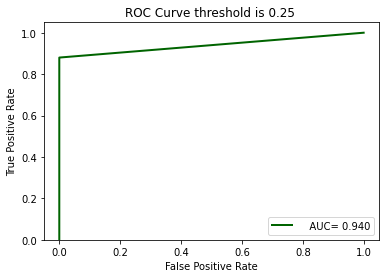

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.25)

### **Threshold = 0.3**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 21
num of samples non covid but predicted covid : 4
total cases that predicted as covid:  83
total cases that predicted as non covid : 3017
Sensitivity is : 0.79
Specificity is : 0.9986666666666667


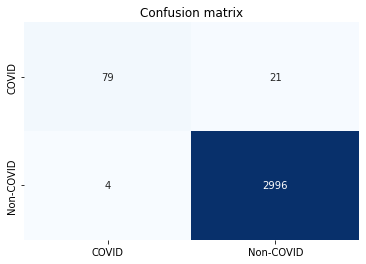

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.3)

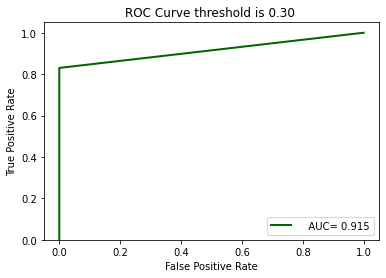

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.3)

### **Threshold = 0.35**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 22
num of samples non covid but predicted covid : 2
total cases that predicted as covid:  80
total cases that predicted as non covid : 3020
Sensitivity is : 0.78
Specificity is : 0.9993333333333333


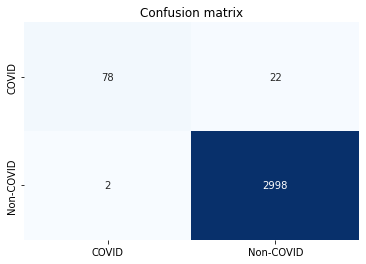

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.35)

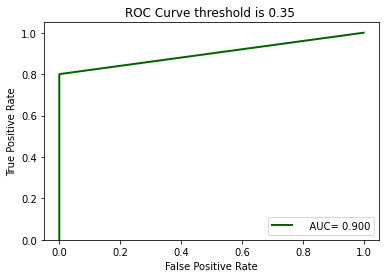

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.35)

### **Threshold = 0.4**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 22
num of samples non covid but predicted covid : 2
total cases that predicted as covid:  80
total cases that predicted as non covid : 3020
Sensitivity is : 0.78
Specificity is : 0.9993333333333333


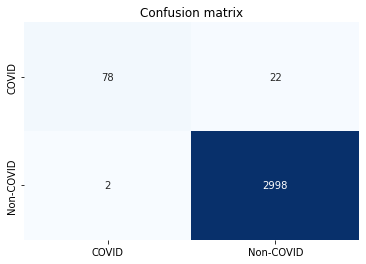

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.4)

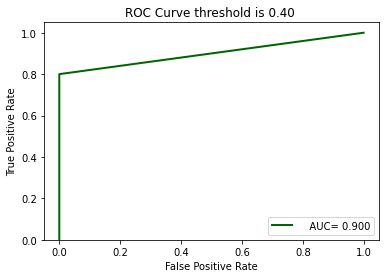

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.4)

### **Threshold = 0.5**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 26
num of samples non covid but predicted covid : 0
total cases that predicted as covid:  74
total cases that predicted as non covid : 3026
Sensitivity is : 0.74
Specificity is : 1.0


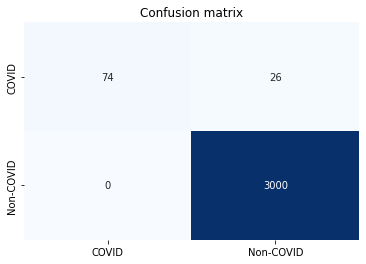

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.5)

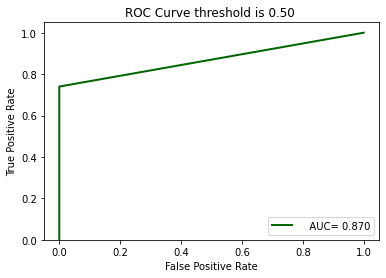

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.5)

# **2nd DensNet 121**

## **code**

In [ ]:
#### load model
model_conv = torchvision.models.densenet121(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
for param in model_conv.features.denseblock4.denselayer16.parameters():
    param.requires_grad = True
for param in model_conv.features.norm5.parameters():
    param.requires_grad = True
        
        

# Parameters of newly constructed modules have requires_grad=True by default   
num_ftrs = model_conv.classifier.in_features        
model_conv.classifier = nn.Linear(num_ftrs, 2)


model_conv = model_conv.to(device)  
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr= 0.001, momentum= 0.9)  

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


if __name__ == "__main__":
    model_conv, train_acc, valid_acc = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, batch_size, num_epochs= epochs)
    model_conv.eval()
    torch.save(model_conv, './covid_densnet121_epoch100_2.pt')




end_time= time.time()
print("total_time tranfer learning=", end_time - start_time)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Epoch 1/100
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Streaming output truncated to the last 5000 lines.
       device='cuda:0')
label: tensor([0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
       device='cuda:0')
98-th epoch, 118-th batch (size=20), train acc= 0.900 


preds: tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1],
       device='cuda:0')
98-th epoch, 119-th batch (size=20), train acc= 0.900 


preds: tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
98-th epoch, 120-th batch (size=20), train acc= 0.900 


preds: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1],
       device='cuda:0')
label: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       device='cuda:0')
98-th epoch, 121-th batch (size=20), train acc= 0.900 

In [ ]:
trained_model_path =  '/content/gdrive/MyDrive/2_covid_densnet121_epoch100_2.pt'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name= trained_model_path
model= torch.load(model_name, map_location='cpu') 
model.eval()

class_names = ['covid','non']


## **Experimnet**

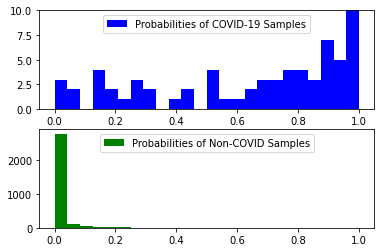

In [ ]:
Probabilties(covid_prob , non_prob)

### **Threshold = 0.03**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 3
num of samples non covid but predicted covid : 298
total cases that predicted as covid:  395
total cases that predicted as non covid : 2705
Sensitivity is : 0.97
Specificity is : 0.9006666666666666


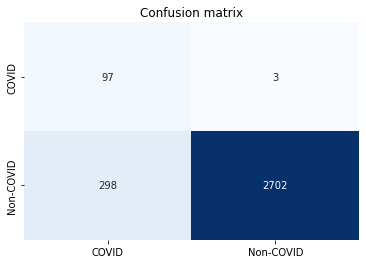

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.03)

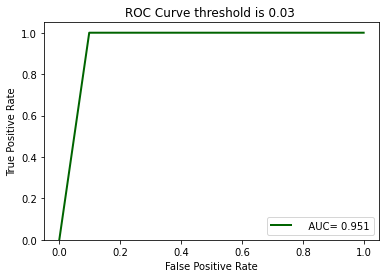

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.03)

### **Threshold = 0.1**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 5
num of samples non covid but predicted covid : 93
total cases that predicted as covid:  188
total cases that predicted as non covid : 2912
Sensitivity is : 0.95
Specificity is : 0.969


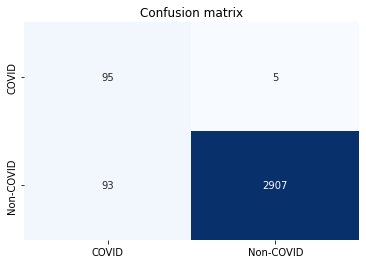

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.1)

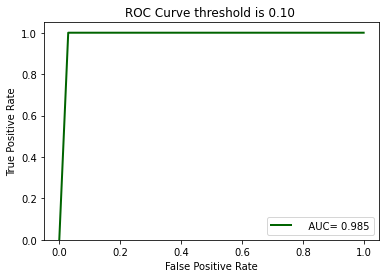

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.1)

### **Threshold = 0.15**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 9
num of samples non covid but predicted covid : 53
total cases that predicted as covid:  144
total cases that predicted as non covid : 2956
Sensitivity is : 0.91
Specificity is : 0.9823333333333333


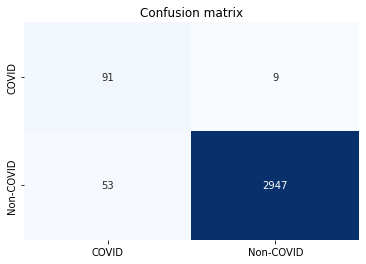

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.15)

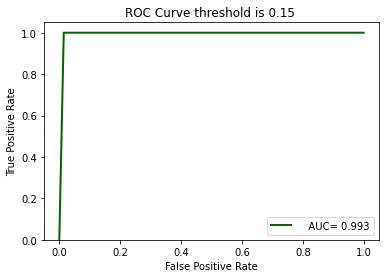

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.15)

### **Threshold = 0.17**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 9
num of samples non covid but predicted covid : 46
total cases that predicted as covid:  137
total cases that predicted as non covid : 2963
Sensitivity is : 0.91
Specificity is : 0.9846666666666667


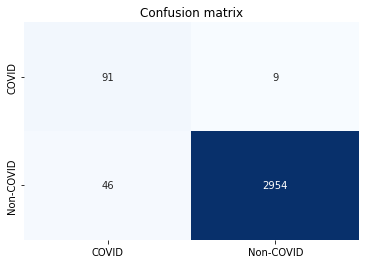

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.17)

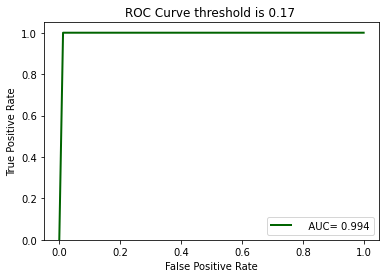

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.17)

### **Threshold = 0.19**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 10
num of samples non covid but predicted covid : 36
total cases that predicted as covid:  126
total cases that predicted as non covid : 2974
Sensitivity is : 0.9
Specificity is : 0.988


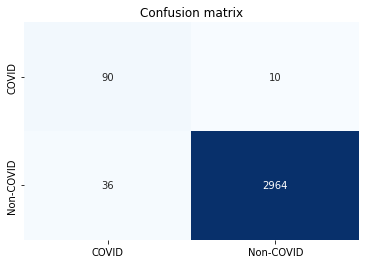

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.19)

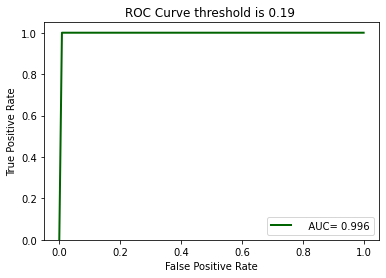

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.19)

### **Threshold = 0.2**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 11
num of samples non covid but predicted covid : 36
total cases that predicted as covid:  125
total cases that predicted as non covid : 2975
Sensitivity is : 0.89
Specificity is : 0.988


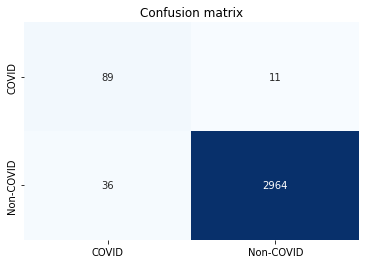

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.2)

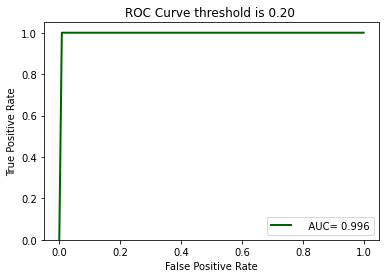

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.2)

### **Threshold = 0.25**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 12
num of samples non covid but predicted covid : 23
total cases that predicted as covid:  111
total cases that predicted as non covid : 2989
Sensitivity is : 0.88
Specificity is : 0.9923333333333333


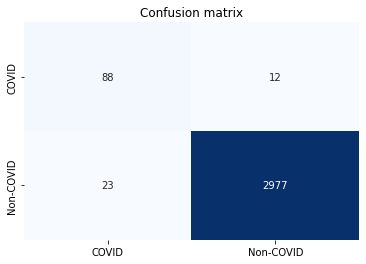

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.25)

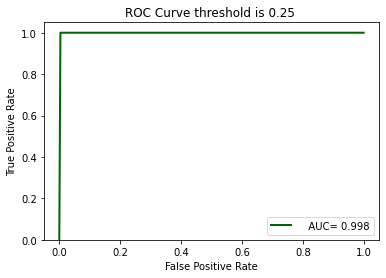

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.25)

### **Threshold = 0.3**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 15
num of samples non covid but predicted covid : 15
total cases that predicted as covid:  100
total cases that predicted as non covid : 3000
Sensitivity is : 0.85
Specificity is : 0.995


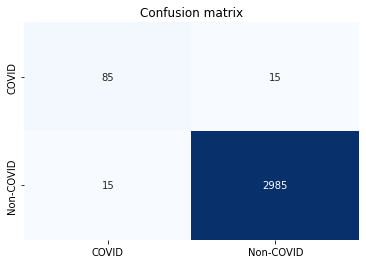

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.3)

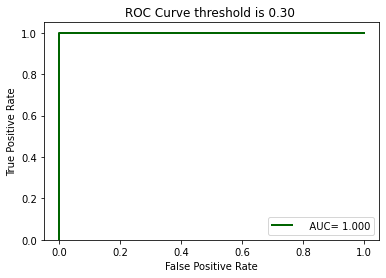

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.3)

### **Threshold = 0.35**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 17
num of samples non covid but predicted covid : 13
total cases that predicted as covid:  96
total cases that predicted as non covid : 3004
Sensitivity is : 0.83
Specificity is : 0.9956666666666667


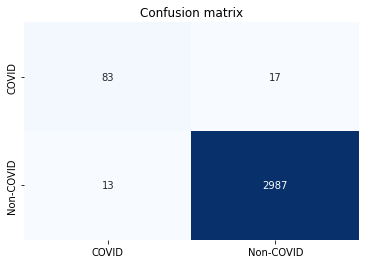

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.35)

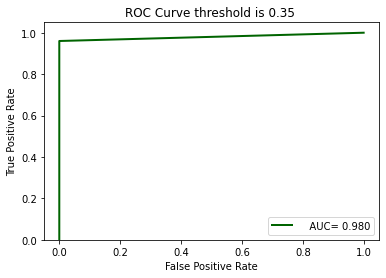

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.35)

### **Threshold = 0.4**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 18
num of samples non covid but predicted covid : 9
total cases that predicted as covid:  91
total cases that predicted as non covid : 3009
Sensitivity is : 0.82
Specificity is : 0.997


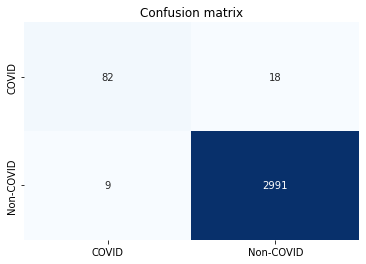

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.4)

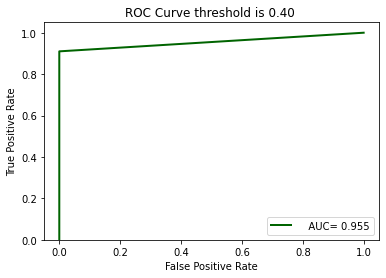

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.4)

### **Threshold = 0.5**

test size is :  3100 sample


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


num of samples covid but predicted non covid : 20
num of samples non covid but predicted covid : 7
total cases that predicted as covid:  87
total cases that predicted as non covid : 3013
Sensitivity is : 0.8
Specificity is : 0.9976666666666667


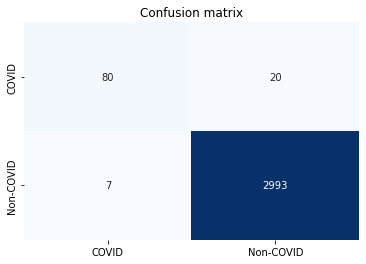

In [ ]:
covid_prob , non_prob ,coivdpred , noncovidpred = testmodel(image_datasets['test'] , 0.5)

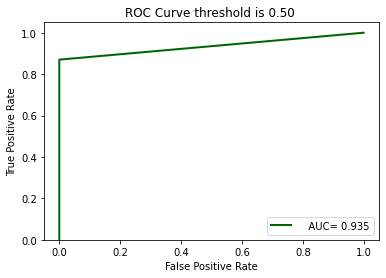

In [ ]:
Roc(covid_prob ,non_prob ,coivdpred,noncovidpred, 0.5)